### Imports

In [14]:
import itertools
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf

from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.metrics import confusion_matrix

from tensorflow import keras

from keras.preprocessing import text, sequence
from keras import utils

### Create plotting function

In [15]:
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

## Read data

In [16]:
train = pd.read_csv('../input/train.csv')
print('Training data shape: ', train.shape)
test = pd.read_csv('../input/test.csv')
print('Testing data shape: ', test.shape)
print(train[train.keyword.isnull()])

Training data shape:  (7613, 5)
Testing data shape:  (3263, 4)
         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheT

## Preprocessing text

In [17]:
# TODO - clean text
# Applying a first round of text cleaning techniques
import re, string
def clean_text(text):
    eyes = "[8:=;]"
    nose = "['`\-]?"
    text = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\), ]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',"<URL>", text)    
    text = re.sub("/"," / ", text)
    text = re.sub('@(\w+)', '<USER>', text)
    text = re.sub('#{eyes}#{nose}[)d]+|[)d]+#{nose}#{eyes}', "<SMILE>", text)
    text = re.sub('#{eyes}#{nose}p+', "<LOLFACE>", text)
    text = re.sub('#{eyes}#{nose}\(+|\)+#{nose}#{eyes}', "<SADFACE>", text)
    text = re.sub('#{eyes}#{nose}[\/|l*]', "<NEUTRALFACE>", text)
    text = re.sub('<3',"<HEART>", text)
    text = re.sub('[-+]?[.\d]*[\d]+[:,.\d]*', "<NUMBER>", text)
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = text.lower()
    #text = re.sub('\[.*?\]', '', text)
    #text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation.replace('<', '').replace('>', '')), '', text)
    text = re.sub('\n', '', text)
    #text = re.sub('\w*\d\w*', '', text)    
    
    return text

import nltk
from nltk import word_tokenize, pos_tag
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
def text_preprocessing(text):
    """
    Cleaning and parsing the text.

    """
    tokenizer = nltk.tokenize.TweetTokenizer(strip_handles=True, reduce_len=True)
    
    lemmatizer = nltk.stem.WordNetLemmatizer() 
  
    nopunc = clean_text(text)
    
    tokenized_text = tokenizer.tokenize(nopunc)
    
    remove_stopwords = [w for w in tokenized_text if w not in stopwords.words('english')]
    
    lemmatized = [lemmatizer.lemmatize(i,j[0].lower()) if j[0].lower() in ['a','n','v'] else lemmatizer.lemmatize(i) for i,j in pos_tag(remove_stopwords)]
    
    combined_text = ' '.join(lemmatized)
    return combined_text

print(train)
train['text'] = train['text'].apply(lambda x: text_preprocessing(x))
test['text'] = test['text'].apply(lambda x: text_preprocessing(x))
print(train)

         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0     Our Deeds are the Reason of this #earthquake M...       1  
1                Forest fire near La Ronge Sask. Canada       1  
2     All residents asked to 'shelter in place' are ...       1  
3     13,000 people receive #wildfires evacuation or...       1  
4     Just got sent this photo from Ruby #Alaska as ...       1  
...                                                 ...     ...  
7608  Two giant cranes holding a bridge collapse int...       1  
7609  @aria_ahrary @TheTawniest The out of control w...       1  
7610  M1.94 [01:04 UT

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Marci\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Marci\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Marci\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Marci\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


         id keyword location  \
0         1     NaN      NaN   
1         4     NaN      NaN   
2         5     NaN      NaN   
3         6     NaN      NaN   
4         7     NaN      NaN   
...     ...     ...      ...   
7608  10869     NaN      NaN   
7609  10870     NaN      NaN   
7610  10871     NaN      NaN   
7611  10872     NaN      NaN   
7612  10873     NaN      NaN   

                                                   text  target  
0            deed reason earthquake may allah forgive u       1  
1                 forest fire near la ronge sask canada       1  
2     resident ask shelter place notify officer evac...       1  
3     <number> people receive wildfire evacuation or...       1  
4     get sent photo ruby alaska smoke wildfires pou...       1  
...                                                 ...     ...  
7608  two giant crane hold bridge collapse nearby ho...       1  
7609  <user> <user> control wild fire california eve...       1  
7610  <number> <numbe

### Create embedding matrix

In [18]:
import numpy as np

def create_embedding_matrix(filepath, word_index, embedding_dim):
    vocab_size = len(word_index) + 1  # Adding again 1 because of reserved 0 index
    embedding_matrix = np.zeros((vocab_size, embedding_dim))

    with open(filepath, encoding="utf8") as f:
        for line in f:
            word, *vector = line.split()
            if word in word_index:
                idx = word_index[word] 
                embedding_matrix[idx] = np.array(
                    vector, dtype=np.float32)[:embedding_dim]

    return embedding_matrix

### Retrieve embedding matrix

In [19]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(train["text"])
vocab_size = len(tokenizer.word_index) + 1
print(tokenizer.word_index)
embedding_dim = 50
embedding_matrix = create_embedding_matrix(
        '../input/glove.twitter.27B.50d.txt',
    #'../input/glove.6B.50d.txt',
    tokenizer.word_index, embedding_dim)

{'url': 1, 'number': 2, 'user': 3, '\x89': 4, 'û': 5, 'get': 6, 'like': 7, 'fire': 8, 'im': 9, 'amp': 10, 'go': 11, 'u': 12, 'new': 13, 'one': 14, 'say': 15, 'people': 16, 'news': 17, 'bomb': 18, 'dont': 19, 'time': 20, 'make': 21, 'kill': 22, 'video': 23, 'disaster': 24, 'emergency': 25, 'come': 26, 'flood': 27, 'burn': 28, 'year': 29, 'body': 30, 'crash': 31, 'see': 32, 'look': 33, 'attack': 34, 'day': 35, 'police': 36, 'home': 37, 'take': 38, 'know': 39, 'would': 40, 'still': 41, 'building': 42, 'family': 43, 'storm': 44, 'think': 45, 'love': 46, 'california': 47, 'back': 48, 'train': 49, 'watch': 50, 'suicide': 51, 'world': 52, 'want': 53, 'death': 54, 'bag': 55, 'car': 56, 'man': 57, 'collapse': 58, 'scream': 59, 'life': 60, 'first': 61, 'pm': 62, 'cause': 63, 'cant': 64, 'rt': 65, 'let': 66, 'need': 67, 'nuclear': 68, 'war': 69, 'two': 70, 'work': 71, 'today': 72, 'dead': 73, 'accident': 74, 'wreck': 75, 'full': 76, 'hiroshima': 77, 'w': 78, 'good': 79, 'destroy': 80, 'drown': 81

In [20]:
nonzero_elements = np.count_nonzero(np.count_nonzero(embedding_matrix, axis=1))
nonzero_elements / vocab_size

0.8111826930724568

### Tokenize

In [21]:
train["text"] = tokenizer.texts_to_sequences(train["text"].values)
test["text"] = tokenizer.texts_to_sequences(test["text"].values)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(train.head())
print(vocab_size)

   id keyword location                                               text  \
0   1     NaN      NaN               [3622, 462, 249, 82, 1328, 2842, 12]   
1   4     NaN      NaN                           [145, 8, 184, 463, 1093]   
2   5     NaN      NaN  [1460, 513, 1591, 402, 328, 202, 1591, 402, 30...   
3   6     NaN      NaN                   [2, 16, 2843, 101, 202, 307, 47]   
4   7     NaN      NaN         [6, 2361, 139, 1592, 198, 3623, 2362, 125]   

   target  
0       1  
1       1  
2       1  
3       1  
4       1  
12573


### Pad sequences

In [22]:
from keras.preprocessing.sequence import pad_sequences

maxlen = 100
train_text = pad_sequences(train["text"].values, padding='post', maxlen=maxlen)
test_text = pad_sequences(test["text"].values, padding='post', maxlen=maxlen)
target = train["target"].values

In [23]:
print(train_text)

[[3622  462  249 ...    0    0    0]
 [ 145    8  184 ...    0    0    0]
 [1460  513 1591 ...    0    0    0]
 ...
 [   2    2  642 ...    0    0    0]
 [  36  804 2608 ...    0    0    0]
 [ 165   37  427 ...    0    0    0]]


### Split training and validation data

In [24]:
from sklearn.model_selection import train_test_split

train_data, validation_data, train_target, validation_target = train_test_split(
   train_text, target, test_size=0.25, random_state=1000)


In [25]:
validation_target.shape


(1904,)

### Create model

In [26]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
from keras import layers

model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(layers.MaxPooling1D(pool_size=2))
model.add(layers.Flatten())
model.add(layers.Dense(1, activation='sigmoid'))

"""
model = Sequential()
model.add(layers.Embedding(vocab_size, embedding_dim, 
                           weights=[embedding_matrix], 
                           input_length=maxlen, 
                           trainable=True))
model.add(layers.GlobalAveragePooling1D())
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
"""

model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
model.summary()




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 100, 50)           628650    
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 96, 128)           32128     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 128)           0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 6144)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 6145      
Total params: 666,923
Trainable params: 666,923
Non-trainable params: 0
_________________________________________________________________




Training Accuracy: 0.9818
Testing Accuracy:  0.7710


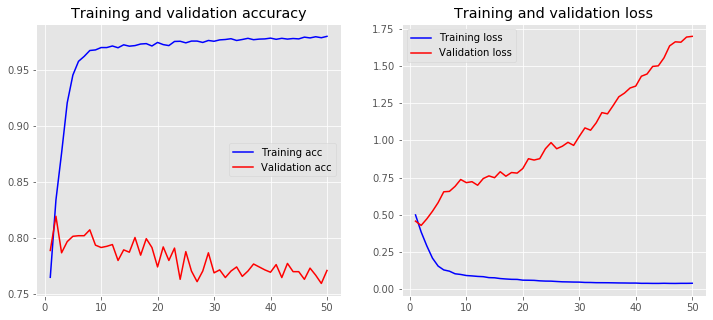

In [27]:
history = model.fit(train_data, train_target,
                    epochs=50,
                    verbose=False,
                    validation_data=(validation_data, validation_target),
                    batch_size=10)
loss, accuracy = model.evaluate(train_data, train_target, verbose=False)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate(validation_data, validation_target, verbose=False)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)

### Predict and create submission

In [28]:
prediction = model.predict(test_text)
print(prediction)

[[6.5762997e-03]
 [1.9371510e-06]
 [9.9998832e-01]
 ...
 [1.0000000e+00]
 [9.9974805e-01]
 [9.9998558e-01]]


In [29]:
submission_data = [1 if p > 0.5 else 0 for p in prediction]
print(len(submission_data))

3263


In [30]:
def submission(submission_file_path,submission_data):
    sample_submission = pd.read_csv(submission_file_path)
    prediction = model.predict(test_text)
    sample_submission["target"] = submission_data
    sample_submission.to_csv("submission.csv", index=False)

In [31]:
submission_file_path = "../input/sample_submission.csv"
submission(submission_file_path,submission_data)

### TODO Impute missing keywords

In [32]:
from sklearn.impute import SimpleImputer

print(X_valid[X_valid["keyword"].isnull()])
print(X_valid["keyword"].shape)

# replace missing keyword with "missing_value"
imputer = SimpleImputer(missing_values=np.NaN, strategy='constant')
X_train["keyword"] = imputer.fit_transform(X_train["keyword"].to_numpy().reshape(-1, 1))
X_valid["keyword"] = imputer.transform(X_valid["keyword"].to_numpy().reshape(-1, 1))

print(X_valid[X_valid["keyword"].isnull()])
print(X_valid[X_valid["id"]  == 10864])



NameError: name 'X_valid' is not defined

### One-hot encode keyword

In [ ]:
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder(sparse=False)

asd = encoder.fit_transform(X_train["keyword"].to_numpy().reshape(-1, 1))
#encoder.transform(X_valid["keyword"].to_numpy().reshape(-1, 1))

print(asd)


In [ ]:
print(asd[0])